# **Using Physical Attributes and Point Perctanges to Predict Position for NBA Players**

##### *Tanisha Amrin, Charmaine Chui, Jakob Sereda, Julian Wright*

## **Introduction**

One of the most popular sports in North America and worldwide (*SportsPro Media*, 2023), games of basketball have been played amongst millions, both professional and amateur, since its invention in 1891 (*National Geographic*, 2021). When it comes to professional basketball, all eyes are on the National Basketball Association (or NBA), which is considered to be the premier professional basketball league in the world (*SportsPro Media*, 2023). Each of the 30 teams in the NBA holds their players to an immense standard of performance, only signing the very best in the world to hit the court wearing their jerseys.

A key aspect of basketball is the numerous positions players take on the court. Each player fills one position, and although there are many roles officially documented, they can be grouped into the three main categories of centers, forwards, and guards, with many hybrids and combinations to fill in the gaps (*Under Armour*). NBA coaches are tasked with appropriately assigning drafted players to positions that will most suit their body type and skill set. The nuances of such a process can have a profound impact on a team's ability to perform, allowing individual players to show their unique talents if placed in the right role (*RedBull*, 2022). The goal of this project is to provide a model that can assist coaches in assigning positions to their players, through statistical analysis and reasoning.

The question we seek to answer is: **What position is a player most likely to play, given their height, weight, free-throw percentage, and field goal percentage?**

The data set we will use to answer this question was pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA, using the NBA API Client package; [*github.com/swar/nba_api*](https://github.com/swar/nba_api)  (Swar Patel, Randall Forbes, et al). It contains stats on individual players during each NBA season. There are 58 columns and 4,917 rows in this data set, missing values are represented by "NA". As there is a large amount of data stored by the NBA, and thus many columns in this data set, we will not list every single column in this data set below. We provide descriptions of the following columns from the data relevant to our analysis below:
- **PERSON_ID:** the given player's id
- **HEIGHT:** player's height in inches
- **WEIGHT:** player's weight in lbs
- **POSITION:** player's position (one of Forward, Center, Guard, Center-Forward, Forward-Center, Guard-Forward, Forward-Guard)
- **FG_PCT:** field goal percentage, value between 0 and 1 (field goals made / field goals attempted)
- **FT_PCT:** free throw percentage, value between 0 and 1 (free throws made / free throws attempted)

## **Preliminary Exploratory Data Analysis**

In [63]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

In [90]:
set.seed(2024) 

# reading in the data from the web
nba_data <- read_csv("https://raw.githubusercontent.com/jakobsereda/dsci-100-project/main/stats.csv", show_col_types = FALSE) 

# cleaning and wrangling the data
names(nba_data) <- tolower(names(nba_data))

nba_clean <- nba_data |>
    select(person_id, first_name, last_name, height, weight, position, season_id, 
           gp, gs, min, fg_pct, fg3_pct, ft_pct, reb, ast, stl, blk, tov, pf, pts) |>
    na.omit() |>
    mutate(position = ifelse(position == "Center-Forward", "Center", position)) |>
    mutate(position = ifelse(position == "Guard-Forward", "Guard", position)) |>
    mutate(position = ifelse(position == "Forward-Guard" | position == "Forward-Center", "Forward", position)) |>
    mutate(position = as_factor(position))

# splitting the data into training and testing sets
nba_split <- initial_split(nba_clean, prop = 3/4, strata = position)

nba_train <- training(nba_split)
nba_test <- testing(nba_split)

head(nba_train)

person_id,first_name,last_name,height,weight,position,season_id,gp,gs,min,fg_pct,fg3_pct,ft_pct,reb,ast,stl,blk,tov,pf,pts
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76003,Kareem,Abdul-Jabbar,86,225,Center,1988-89,74,74,1695,0.475,0.000,0.739,334,74,38,85,95,196,748
201582,Alexis,Ajinca,86,248,Center,2016-17,39,15,584,0.500,0.000,0.725,177,12,20,22,31,77,207
202374,Solomon,Alabi,85,252,Center,2011-12,14,0,122,0.361,0.000,0.875,47,3,2,9,5,11,33
202332,Cole,Aldrich,83,253,Center,2017-18,21,0,49,0.333,0.000,0.333,15,3,2,1,1,11,12
200746,LaMarcus,Aldridge,83,250,Center,2021-22,47,12,1050,0.550,0.304,0.873,258,42,14,47,44,78,607
76021,Chuck,Aleksinas,83,260,Center,1984-85,74,4,1114,0.478,0.000,0.733,270,36,15,15,72,171,377


In [91]:
# summarizing the number of players in each position, and the min, max, and mean of each predictor for each position
nba_summarized <- nba_train |>
    group_by(position) |>
    summarize(min_height = min(height), max_height = max(height), mean_height = mean(height),
              min_weight = min(weight), max_weight = max(weight), mean_weight = mean(weight),
              min_fg_pct = min(fg_pct), max_fg_pct = max(fg_pct), mean_fg_pct = mean(fg_pct),
              min_ft_pct = min(ft_pct), max_ft_pct = max(ft_pct), mean_ft_pct = mean(ft_pct),
              n_players = n())

nba_summarized

position,min_height,max_height,mean_height,min_weight,max_weight,mean_weight,min_fg_pct,max_fg_pct,mean_fg_pct,min_ft_pct,max_ft_pct,mean_ft_pct,n_players
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Forward,71,86,80.11799,153,289,226.2340,0,1,0.4092183,0,1,0.6031200,1017
Center,79,91,83.36118,195,360,250.5577,0,1,0.4317838,0,1,0.5567199,407
Guard,65,84,75.56789,133,255,194.8569,0,1,0.3732541,0,1,0.6561018,1090


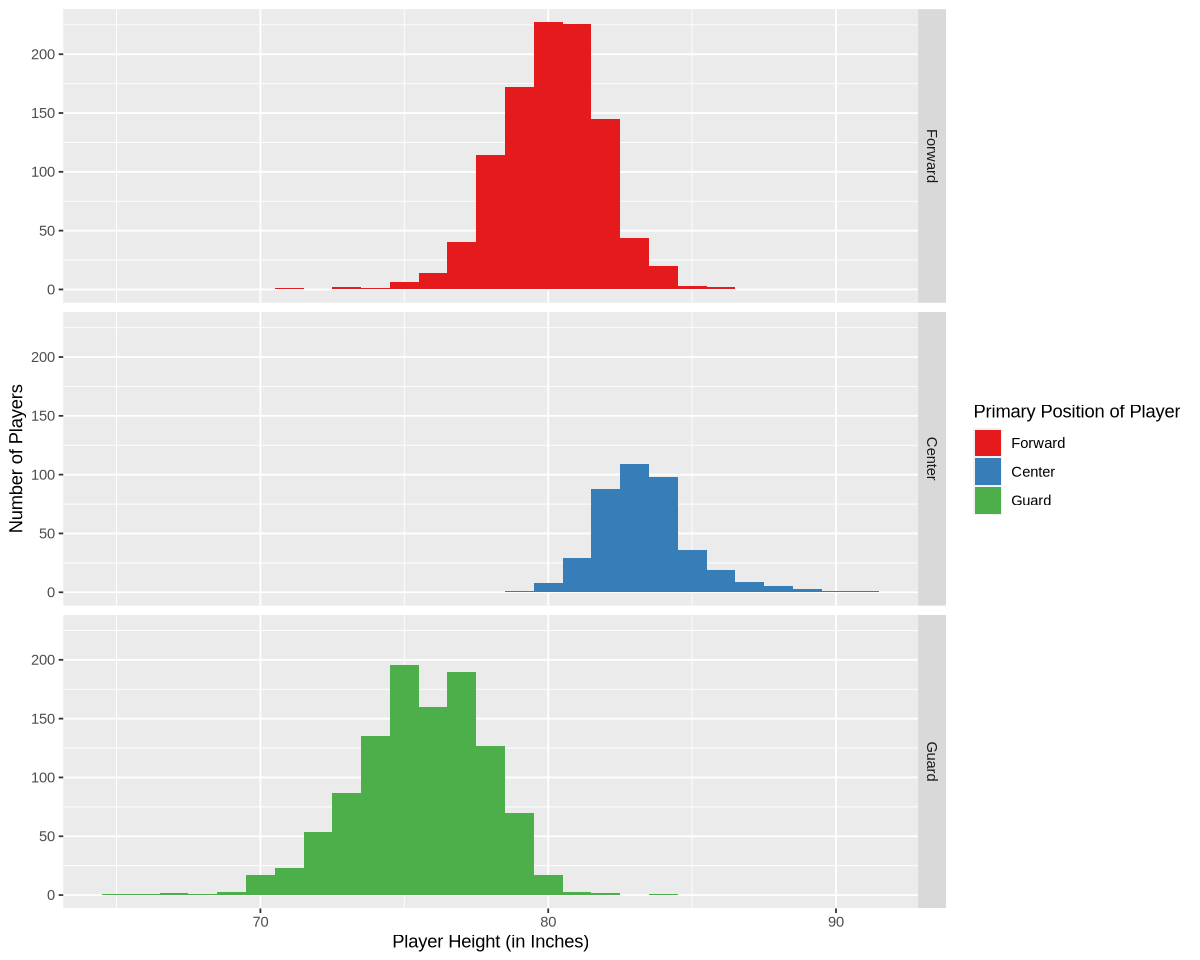

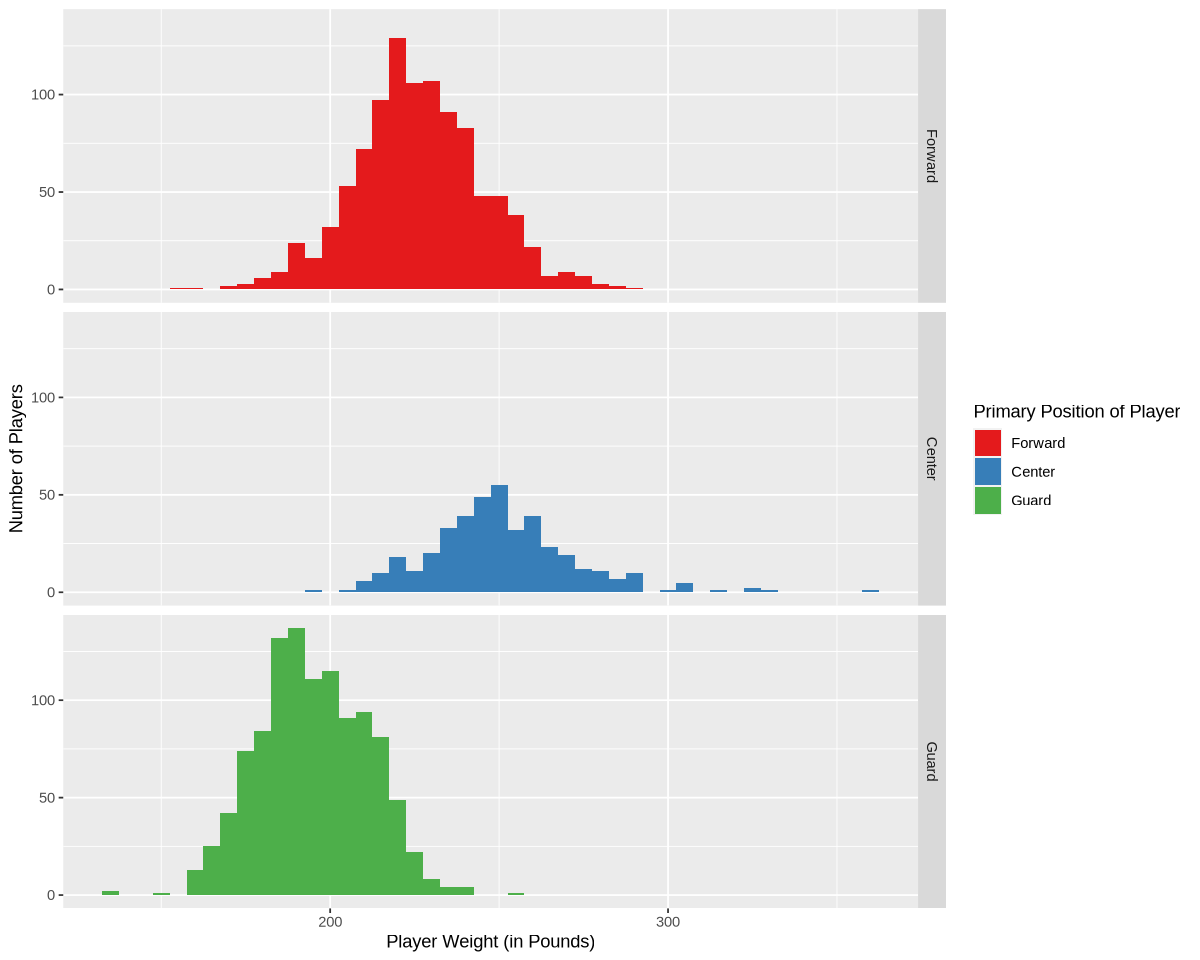

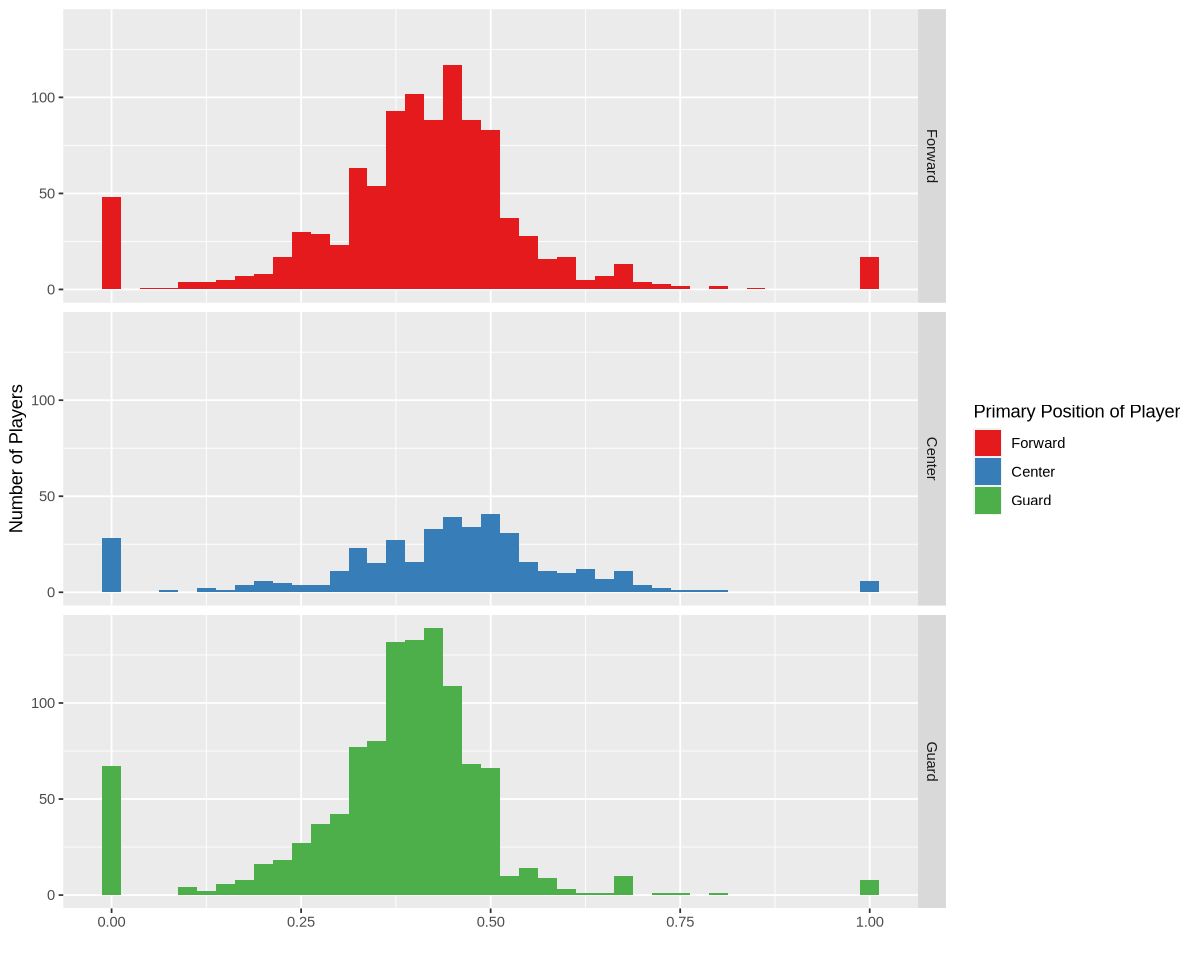

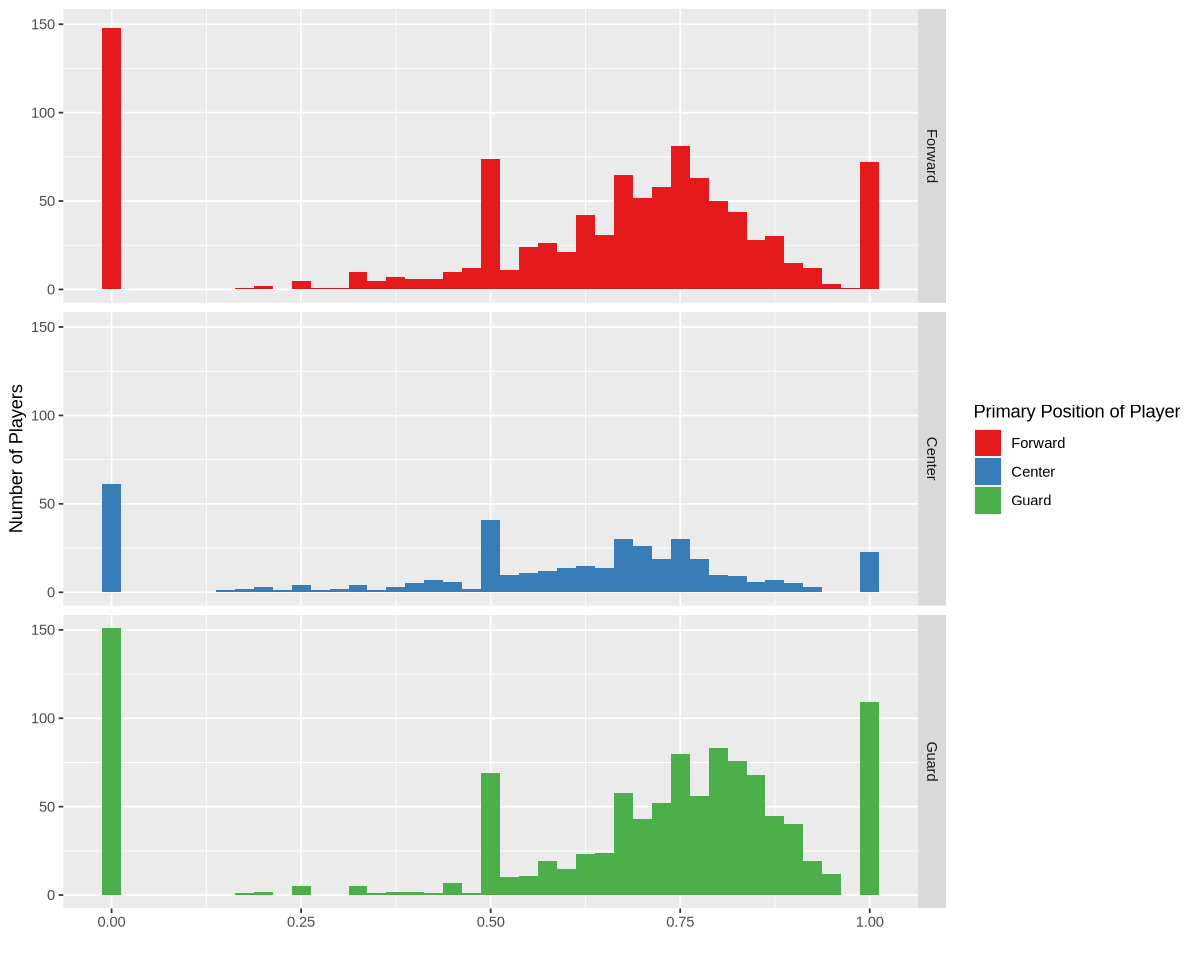

In [88]:
options(repr.plot.width = 10, repr.plot.height = 8)

# plotting the distributions of the predictors for each position (using training data)
nba_plot_height <- nba_train |>
    ggplot(aes(x = height, fill = position)) +
        geom_histogram(binwidth = 1) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Height (in Inches)", y = "Number of Players", fill = "Primary Position of Player") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_weight <- nba_train |>
    ggplot(aes(x = weight, fill = position)) +
        geom_histogram(binwidth = 5) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Weight (in Pounds)", y = "Number of Players", fill = "Primary Position of Player") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_fg_pct <- nba_train |>
    ggplot(aes(x = fg_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "", y = "Number of Players", fill = "Primary Position of Player") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_ft_pct <- nba_train |>
    ggplot(aes(x = ft_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "", y = "Number of Players", fill = "Primary Position of Player") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_height
nba_plot_weight
nba_plot_fg_pct
nba_plot_ft_pct

## **Methods**

## **Expected Outcome and Significance**

We expect to find that:
- Players classified as **Centers** will, on average, tend to be taller, weigh more, have higher field goal percentages, and lower free throw percentages
- Players classified as **Guards** will, on average, tend to be shorter, weigh less, have lower field goal percentages, and higher free throw percentages
- Players classified as **Forwards** will, on average, tend to split the difference between the observed stats for Centers and Guards ('average' height, weight, field goal percentage, and free throw percentage, relatively speaking)

The significance of this outcome would come with how NBA teams could utilize it to their advantage in planning team composition

## **Bibliography**

- Data is pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA, 
   using the NBA API Client package; [*github.com/swar/nba_api*](https://github.com/swar/nba_api) (Swar Patel, Randall Forbes, et al). *Note: this dataset was not provided on Canvas, but was approved by a TA during tutorial.*
- McMurray, Ben. "Why the NBA is America's Most Globally Relevant Sports Property." *SportsPro Media*, 24 Oct. 2023, [*link*](https://www.sportspromedia.com/insights/analysis/nba-tv-rights-revenue-global-popularity-data-ampere-analysis/).
- Toole, T.C. "Here's the History of Basketball - From Peach Baskets in Springfield to Global Phenomenon." *National Geographic*, 27 Mar. 2021, [*link*](https://www.nationalgeographic.com/history/article/basketball-only-major-sport-invented-united-states-how-it-was-created).
- "What are the 5 Basketball Positions and Their Roles?", *Under Armour*, [*link*](https://www.underarmour.com/en-us/t/playbooks/basketball/basketball-positions/).
- Lister, Aimee. "Basketball Positions Explained: What Each Player Does." *RedBull*, 21 Jul. 2022, [*link*](https://www.redbull.com/us-en/basketball-positions-what-each-player-does#:~:text=Generally%20speaking%2C%20each%20team%20is,handling%2C%20passing%20and%20shooting%20skills.).